In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("data/Homework8.csv",parse_dates=['time'], index_col='time')
df.head()

,Unnamed: 0,merchant,amount_usd_in_cents
time,,,
2034-06-17 23:34:14,1,faa029c6b0,6349
2034-12-27 00:40:38,2,ed7a7d91aa,3854
2034-04-30 01:29:42,3,5608f200cf,789
2034-09-16 01:06:23,4,15b1a0d61e,4452
2034-07-22 16:21:42,5,4770051790,20203


In [3]:
# Let's drop de Unnamed:0 column
df.drop(["Unnamed: 0",'merchant'], axis=1, inplace=True)

# Sort the DataFrame by the index (date)
df = df.sort_index()

df.head()

,amount_usd_in_cents
time,
2033-01-01 09:38:32,4335
2033-01-01 12:53:52,6019
2033-01-01 15:08:55,3942
2033-01-01 15:16:32,1926
2033-01-01 15:19:16,4839


In [4]:
# Filter transactions just to be between 2033,01,01 to 2035,01,01
start_date = '2033-01-01'
end_date = '2035-01-01'

# Filter the DataFrame for dates between 2033/1/1 and 2035/1/1
filtered_df = df.loc[start_date:end_date]
df.head()

,amount_usd_in_cents
time,
2033-01-01 09:38:32,4335
2033-01-01 12:53:52,6019
2033-01-01 15:08:55,3942
2033-01-01 15:16:32,1926
2033-01-01 15:19:16,4839


In [5]:
df['amount_usd'] = df['amount_usd_in_cents'] / 100
df.drop(['amount_usd_in_cents'],axis=1, inplace=True)
df.head()

,amount_usd
time,
2033-01-01 09:38:32,43.35
2033-01-01 12:53:52,60.19
2033-01-01 15:08:55,39.42
2033-01-01 15:16:32,19.26
2033-01-01 15:19:16,48.39


In [6]:
# Resample the data to get daily sums
df = df.resample('D').sum()[['amount_usd']]
df.head()

,amount_usd
time,
2033-01-01,4415.40
2033-01-02,4758.62
2033-01-03,6283.53
2033-01-04,4851.11
2033-01-05,10016.21


In [7]:
print(type(df))


<class 'pandas.core.frame.DataFrame'>


In [8]:
df.shape

(730, 1)

In [9]:
# Verify index type
print(df.index.dtype)



datetime64[ns]


<Axes: xlabel='time'>

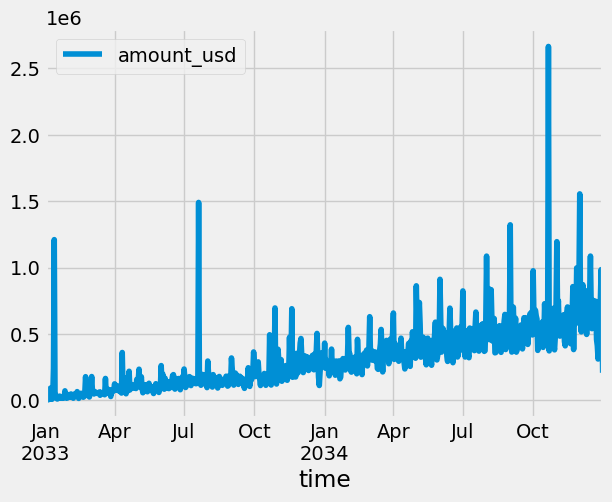

In [10]:
df.plot()

In [11]:
df2 = df.copy()

In [12]:
# SARIMA text ----- didn't go too well

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15256.525, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15530.150, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15431.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15265.014, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15528.205, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15252.268, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15266.417, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15264.195, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15296.976, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15260.693, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15255.288, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15242.204, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15241.414, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]  

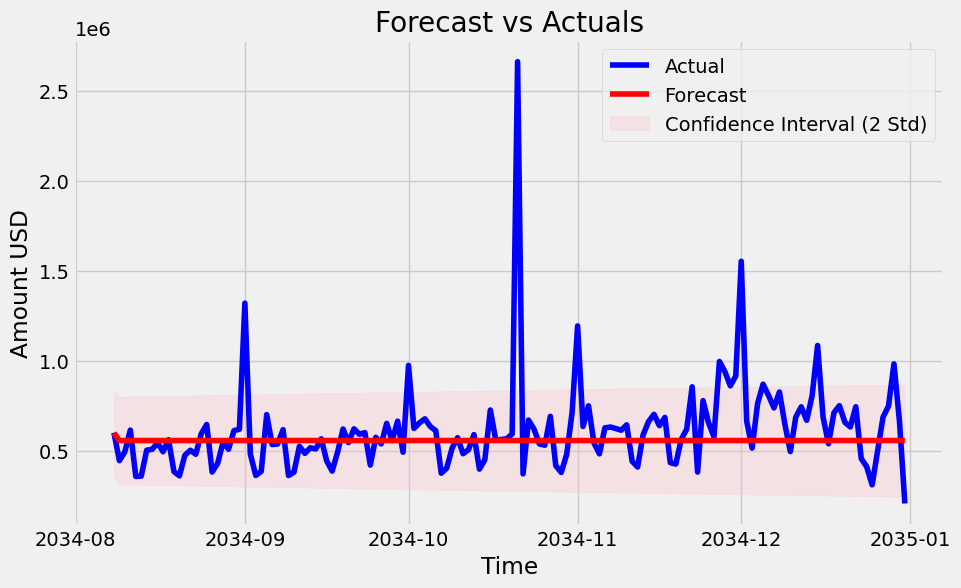

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


# 1. Split the data into training and testing
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 2. Use auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(train, seasonal=True, stepwise=True,
                              suppress_warnings=True, error_action='ignore', max_order=None, trace=True)

# 3. Train the ARIMA model with the best parameters
order = auto_arima_model.order
arima_model = ARIMA(train, order=order)
arima_result = arima_model.fit()

# 4. Forecast
forecast = arima_result.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Extract the forecast standard error to calculate confidence intervals manually
stderr = forecast.se_mean
ci_upper = mean_forecast + 2 * stderr
ci_lower = mean_forecast - 2 * stderr

# 5. Plot
plt.figure(figsize=(10, 6))
time = test.index
plt.plot(time, test, label='Actual', color='blue')
plt.plot(time, mean_forecast, label='Forecast', color='red')
plt.fill_between(time, ci_lower, ci_upper, color='pink', alpha=0.3, label='Confidence Interval (2 Std)')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Amount USD')
plt.legend()
plt.show()


In [14]:
df

,amount_usd
time,
2033-01-01,4415.40
2033-01-02,4758.62
2033-01-03,6283.53
2033-01-04,4851.11
2033-01-05,10016.21
...,...
2034-12-27,688573.47
2034-12-28,750020.80
2034-12-29,984672.08


In [15]:
# LSTM just on values alone, no feature engineering

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 30 # Number of periods to look back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Epoch 1/20
553/553 - 5s - loss: 0.0020 - 5s/epoch - 9ms/step
Epoch 2/20
553/553 - 1s - loss: 0.0017 - 1s/epoch - 3ms/step
Epoch 3/20
553/553 - 1s - loss: 0.0017 - 1s/epoch - 3ms/step
Epoch 4/20
553/553 - 1s - loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 5/20
553/553 - 1s - loss: 0.0016 - 1s/epoch - 3ms/step
Epoch 6/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 7/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 8/20
553/553 - 1s - loss: 0.0016 - 1s/epoch - 3ms/step
Epoch 9/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 10/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 11/20
553/553 - 1s - loss: 0.0014 - 1s/epoch - 3ms/step
Epoch 12/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 13/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 14/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 15/20
553/553 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 16/20
553/553 - 1s - loss: 0.0015 - 1s/epoch - 3ms/step
Epoch 17/20
553/5

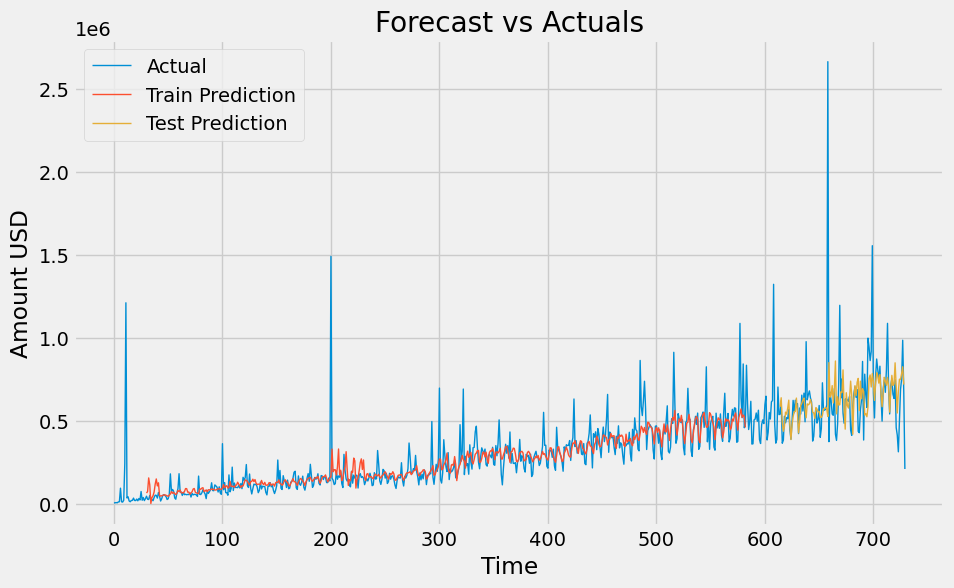

Test MAPE: 19.34%


In [17]:

plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data), linewidth=1)  # Actual
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict, linewidth=1)  # Train Prediction
plt.plot(np.arange(len(trainPredict) + (look_back*2) + 1, len(trainPredict) + (look_back*2) + 1 + len(testPredict)), testPredict, linewidth=1)  # Test Prediction
plt.title('Forecast vs Actuals')
plt.ylabel('Amount USD')
plt.xlabel('Time')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'], loc='best')
plt.show()

# Add code to calculate and print the MAPE for the test set
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

testMAPE = mean_absolute_percentage_error(testY[0], testPredict[:,0])
print('Test MAPE: %.2f%%' % (testMAPE))


In [18]:
df.shape

(730, 1)

In [19]:
df.tail()

,amount_usd
time,
2034-12-27,688573.47
2034-12-28,750020.80
2034-12-29,984672.08
2034-12-30,668559.95
2034-12-31,208533.08


In [21]:
# First number is rows used in training, second is features used (in this case one), last is the loopback days
trainX.shape

(553, 1, 30)

2D Structure (Lagged Columns Approach)

Structure: Each row in the dataset represents a single day, augmented with 30 additional columns, each column representing a lagged value of the stock price from 1 to 30 days ago.

Dimensionality: The resulting dataset is a 2D array or table, where the dimensions are [number_of_days, 1 + 30] (assuming the original value plus 30 lagged values).

Model Interpretation: Each lagged value is treated as an independent feature by the model. This approach does not inherently preserve the temporal order of the values in the way the model processes them, although the model can still infer relationships based on the lagged feature positions.

3D Structure (Sequence Creation Approach)

Structure: The data is organized into sequences, where each sequence is a contiguous 30-day window of historical data leading up to the next day's value that is to be predicted.

Dimensionality: The dataset is a 3D array, with dimensions [number_of_sequences, sequence_length (30), number_of_features_per_day]. This structure is inherently temporal and is designed to be processed by models that can handle sequential data, such as RNNs or LSTMs.

Model Interpretation: The model receives each sequence as a single input, preserving the temporal order and relationships within the sequence. This allows the model to learn from the dynamics and patterns over time, which is particularly advantageous for capturing complex temporal dependencies.

Same Historical Information, Different Representation
While both methods encapsulate the same historical data (the past 30 numerical values), the key difference lies in their representation:

The 2D lagged columns approach presents historical data as independent features for each day, suitable for a wide range of machine learning models but without an explicit emphasis on the sequential nature of the data.

The 3D sequence creation approach structures the data in a way that highlights its temporal sequence, making it ideal for models specifically designed to capture temporal relationships and dynamics.
The choice between these approaches depends on the model you intend to use and how important the temporal sequence and relationships within the data are for your predictive task.

In [ ]:
####################################################################################################################

In [22]:
# LSTM where we add the columns for day of month, day of week, month, year

In [23]:
df = df2.copy()

In [24]:
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
#df['rolling_mean_30d'] = df['amount_usd'].rolling(window=30).mean().shift(1)


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Scale amount_usd
amount_usd_scaler = MinMaxScaler(feature_range=(0, 1))
amount_usd_scaled = amount_usd_scaler.fit_transform(df[['amount_usd']])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['day_of_week', 'day_of_month', 'month', 'year']])

# Concatenate scaled and encoded features
scaled_and_encoded = np.concatenate([amount_usd_scaled, encoded_features], axis=1)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), 1:]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_and_encoded, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
#model.add(Dense(16))
model.add(Dense(1,'linear'))
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=2)

# Predict
predictions = model.predict(X_test)

# Inverse transform predictions
# Note: You only need to inverse transform amount_usd, not the encoded features
predictions_rescaled = amount_usd_scaler.inverse_transform(predictions)
predictions = predictions_rescaled

D:\ComputerCode\JF_Environments\deep2-env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
18/18 - 3s - loss: 0.0126 - 3s/epoch - 144ms/step
Epoch 2/50
18/18 - 0s - loss: 0.0042 - 210ms/epoch - 12ms/step
Epoch 3/50
18/18 - 0s - loss: 0.0027 - 177ms/epoch - 10ms/step
Epoch 4/50
18/18 - 0s - loss: 0.0021 - 194ms/epoch - 11ms/step
Epoch 5/50
18/18 - 0s - loss: 0.0021 - 169ms/epoch - 9ms/step
Epoch 6/50
18/18 - 0s - loss: 0.0019 - 167ms/epoch - 9ms/step
Epoch 7/50
18/18 - 0s - loss: 0.0017 - 191ms/epoch - 11ms/step
Epoch 8/50
18/18 - 0s - loss: 0.0018 - 156ms/epoch - 9ms/step
Epoch 9/50
18/18 - 0s - loss: 0.0017 - 148ms/epoch - 8ms/step
Epoch 10/50
18/18 - 0s - loss: 0.0017 - 186ms/epoch - 10ms/step
Epoch 11/50
18/18 - 0s - loss: 0.0016 - 175ms/epoch - 10ms/step
Epoch 12/50
18/18 - 0s - loss: 0.0015 - 174ms/epoch - 10ms/step
Epoch 13/50
18/18 - 0s - loss: 0.0016 - 181ms/epoch - 10ms/step
Epoch 14/50
18/18 - 0s - loss: 0.0016 - 193ms/epoch - 11ms/step
Epoch 15/50
18/18 - 0s - loss: 0.0016 - 173ms/epoch - 10ms/step
Epoch 16/50
18/18 - 0s - loss: 0.0016 - 172ms/epoch - 1

MAPE: 0.1651074371318297


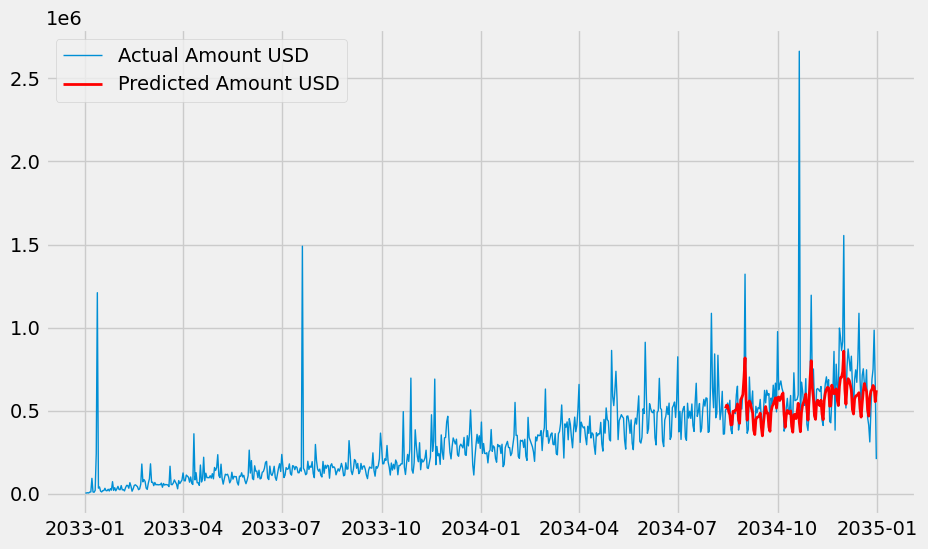

In [26]:
# Calculate MAPE
true_values = df['amount_usd'][-len(predictions):]
mape = mean_absolute_percentage_error(true_values, predictions)
print(f'MAPE: {mape}')

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['amount_usd'], label='Actual Amount USD', linewidth=1)
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Amount USD', color='red',linewidth=2)
plt.legend()
plt.show()


In [27]:
# In this case we 30 days loopback and 52 features (31 days of month + 7 days of week + 12 months + 2 year)
X.shape

(700, 30, 52)

In [ ]:
######################################################################################################################

In [28]:
#LSTM with encoded date features AND the amount lagged as well 

In [29]:
df = df2.copy()
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
#df['rolling_mean_30d'] = df['amount_usd'].rolling(window=30).mean().shift(1)


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Assume df is your pandas DataFrame

# Scale amount_usd
amount_usd_scaler = MinMaxScaler(feature_range=(0, 1))
amount_usd_scaled = amount_usd_scaler.fit_transform(df[['amount_usd']])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['day_of_week', 'day_of_month', 'month', 'year']])

# Concatenate scaled amount_usd and encoded features
scaled_and_encoded = np.concatenate([amount_usd_scaled, encoded_features], axis=1)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        # Include the scaled amount_usd in the input features
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, 0]  # Target is the future amount_usd
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_and_encoded, seq_length)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))  # Predicting a single value
model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=2)

# Predict
predictions = model.predict(X_test)

# Inverse transform predictions to get the original scale
predictions_rescaled = amount_usd_scaler.inverse_transform(predictions.reshape(-1, 1))
predictions = predictions_rescaled

D:\ComputerCode\JF_Environments\deep2-env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
18/18 - 3s - loss: 0.0095 - 3s/epoch - 141ms/step
Epoch 2/50
18/18 - 0s - loss: 0.0036 - 187ms/epoch - 10ms/step
Epoch 3/50
18/18 - 0s - loss: 0.0023 - 191ms/epoch - 11ms/step
Epoch 4/50
18/18 - 0s - loss: 0.0023 - 178ms/epoch - 10ms/step
Epoch 5/50
18/18 - 0s - loss: 0.0020 - 181ms/epoch - 10ms/step
Epoch 6/50
18/18 - 0s - loss: 0.0019 - 191ms/epoch - 11ms/step
Epoch 7/50
18/18 - 0s - loss: 0.0020 - 176ms/epoch - 10ms/step
Epoch 8/50
18/18 - 0s - loss: 0.0018 - 180ms/epoch - 10ms/step
Epoch 9/50
18/18 - 0s - loss: 0.0016 - 165ms/epoch - 9ms/step
Epoch 10/50
18/18 - 0s - loss: 0.0016 - 169ms/epoch - 9ms/step
Epoch 11/50
18/18 - 0s - loss: 0.0017 - 172ms/epoch - 10ms/step
Epoch 12/50
18/18 - 0s - loss: 0.0017 - 174ms/epoch - 10ms/step
Epoch 13/50
18/18 - 0s - loss: 0.0015 - 165ms/epoch - 9ms/step
Epoch 14/50
18/18 - 0s - loss: 0.0015 - 186ms/epoch - 10ms/step
Epoch 15/50
18/18 - 0s - loss: 0.0014 - 190ms/epoch - 11ms/step
Epoch 16/50
18/18 - 0s - loss: 0.0015 - 173ms/epoch - 

MAPE: 0.16537828288241166


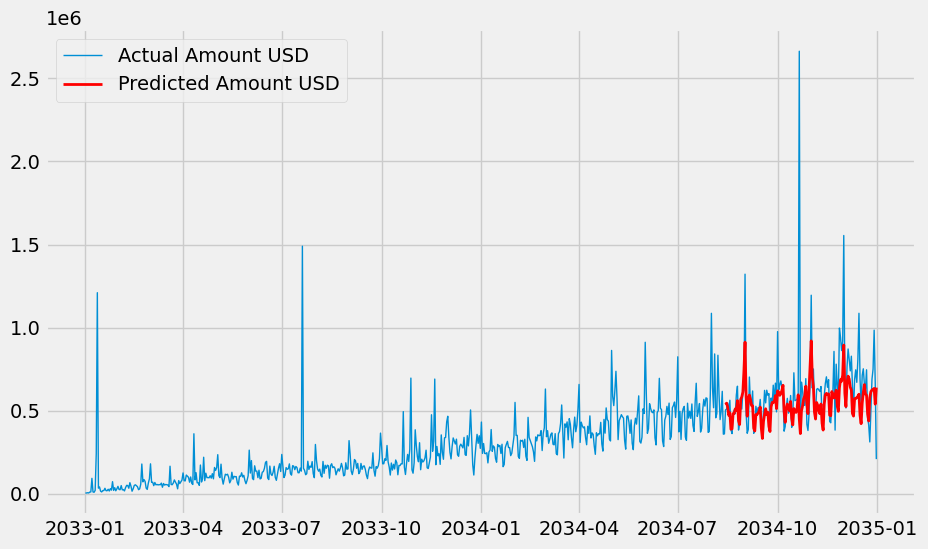

In [31]:
# Calculate MAPE
true_values = df['amount_usd'][-len(predictions):]
mape = mean_absolute_percentage_error(true_values, predictions)
print(f'MAPE: {mape}')

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['amount_usd'], label='Actual Amount USD', linewidth=1)
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Amount USD', color='red',linewidth=2)
plt.legend()
plt.show()


In [32]:
X.shape

(700, 30, 53)